## Vector quantisation

In [1]:
from sklearn.cluster import KMeans
import librosa
import librosa.core.spectrum
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal

In [2]:
# read file (stereo)
original, fs = librosa.core.load("../data/trance.wav", sr=44100, mono=False)

In [3]:
# process
spectrogram = [librosa.core.stft(original[0], n_fft=1024), librosa.core.stft(original[1], n_fft=1024)]
abs_spectrogram = np.abs(spectrogram)

In [4]:
# quantisation
quantised_spectrogram = np.clip((10 * np.sqrt(abs_spectrogram, out=np.zeros_like(abs_spectrogram), where=(abs_spectrogram != 0))).round(), -127, 127)

In [5]:
# Concatenate left and right channels in time axis
con_spectrogram = np.column_stack([quantised_spectrogram[0], quantised_spectrogram[1]])

In [6]:
# Prepare k-means
n_frequencies, n_frames = con_spectrogram.shape
compression_factor = 4
kmeans = KMeans(n_clusters=n_frames//compression_factor, random_state=0, n_init="auto")

In [7]:
# Compute centroids
res = kmeans.fit(con_spectrogram.T)

In [8]:
res.cluster_centers_.shape

(2050, 513)

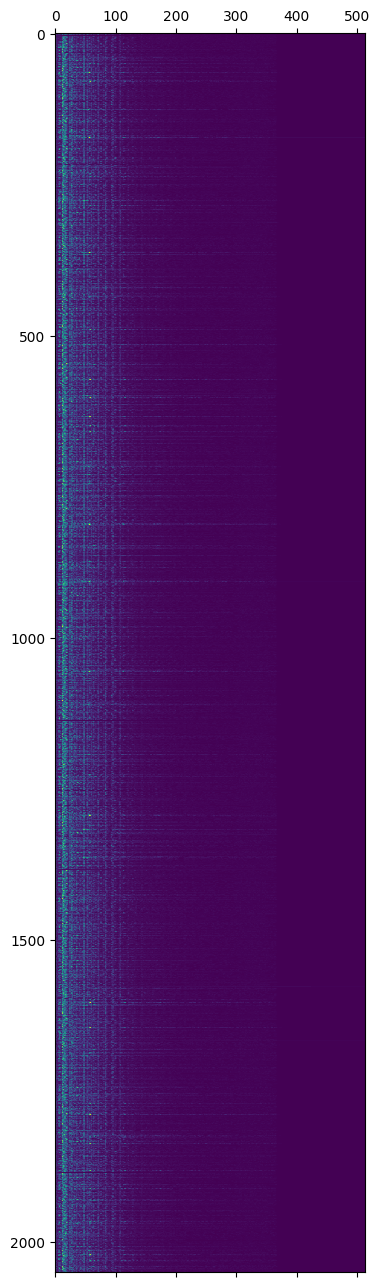

In [9]:
plt.matshow(res.cluster_centers_)

In [10]:
np.save("centroids.npy", (res.cluster_centers_.round()).astype(np.int8))
np.save("labels.npy", (res.labels_).astype(np.int32))

In [11]:
# Writing and reading from fs is ommitted here. See veco.py

In [13]:
reconstructed = res.cluster_centers_[res.labels_].T
reconstructed.shape

(513, 8202)

In [14]:
n_frequencies, n_frames = reconstructed.shape
reconstructed = np.array([reconstructed[:, 0:n_frames // 2], reconstructed[:, n_frames//2:]])

In [15]:
reconstructed = np.square(reconstructed/10)

In [18]:
reconstructed_waveform = np.vstack((librosa.core.spectrum.griffinlim(reconstructed[0]), librosa.core.spectrum.griffinlim(reconstructed[1]))) # Undo STFT
sf.write('centroids.wav', reconstructed_waveform.T, 44100)

In [ ]:
# For export
plt.matshow(np.flip(centroids.cluster_centers_[0:200, 0:150].T))
plt.axis("off")
plt.savefig("codebook.png", dpi=150)

In [21]:
res.cluster_centers_.max()

97.0